In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import torch
import msBO
from msBO import plot_msGP_over_states
from msBO.utils import plot_2D_projection

In [2]:
n_init = 5
n_eval = 5
beta = 4

In [3]:
n_control = 2
n_obj = 2
n_state_PV = 1
n_state = 3

control_CSETs = [f'PSC{i}:I_CSET' for i in range(n_control)]
control_RDs = [f'PSC{i}:I_RD' for i in range(n_control)]
control_tols = [0.1]*len(control_CSETs)
control_min  = [0.0]*len(control_CSETs)
control_max  = [1.0]*len(control_CSETs)
state_CSETs  = [f'SLIT{i}:POS_CSET' for i in range(n_state_PV)]
state_RDs  = [f'SLIT{i}:POS_RD' for i in range(n_state_PV)]
state_tols   = [0.1]*len(state_CSETs)
state_vals   = [[i]*n_state_PV for i in range(n_state)]
state_names  = [f'Ca{19+i}+' for i in range(n_state)]
objective_PVs= [f'BPM{i}:XPOS_RD' for i in range(n_obj)]
monitor_PVs  = []

In [4]:
vm = msBO.virtual_machineIO.VM( 
    control_CSETs = control_CSETs + state_CSETs,
    control_RDs = control_RDs + state_RDs,
    monitor_PVs= objective_PVs + monitor_PVs,
    control_min= control_min + [0]*n_state_PV,
    control_max= control_max + [n_state-1]*n_state_PV,
    monitor_min= [-4]*(len(objective_PVs)+len(monitor_PVs)),
    monitor_max= [ 4]*(len(objective_PVs)+len(monitor_PVs)),
)

machineIO = msBO.construct_machineIO.construct_machineIO(
    virtual_machineIO=vm, 
    set_manually=False)

In [5]:
def projection_plot_model(msbo,candidates,data_only=False,grid_ponits_each_dim=32):

    def func_obj(x):
            with torch.no_grad():
                result = msbo.msGP.predict(x,multi_state_objective_fn=multi_state_objective_fn)
            return result.obj_mean.numpy()

    fig, ax = plt.subplots(1, 1, figsize=(4, 3.3))

    if not data_only:
        plot_2D_projection(
            func_obj,
            bounds = msbo.control_bounds,
            dim_xaxis = 0,
            dim_yaxis = 1,
            grid_ponits_each_dim = grid_ponits_each_dim,
            fig = fig,
            ax  = ax)
    for i in range(len(candidates)):
        ax.scatter(candidates[i,0],candidates[i,1],label=f'candidate after epoch {i}')
    ax.set_title('Model Predicted Objective')
    ax.set_xlim(-0.01,1.01)
    ax.set_ylim(-0.01,1.01)
    ax.set_xlabel(control_RDs[0])
    ax.set_ylabel(control_RDs[1])
    ax.legend()
    fig.tight_layout()

In [6]:
def projection_plot(msbo,candidates,data_only=False,grid_ponits_each_dim=32):
  
    # def func_obj(x,i_state,i_obj):
    #     with torch.no_grad():
    #         result = msbo.msGP.predict(x,multi_state_objective_fn=multi_state_objective_fn)
    #     return result.mean[:,i_state,i_obj].numpy()
        
    fig, ax = plt.subplots(n_obj, n_state, figsize=(4*n_state, 3.3*n_obj))
    
    for i_state in range(n_state):
        for i_obj in range(n_obj):
            # def fun(x):
            #     return func_obj(x,i_state,i_obj)
            def fun(x):
                y = np.zeros(len(x))
                for i,x_ in enumerate(x):
                    f = msbo.evaluator.submit(x_,istate=i_state)
                    df,_ = msbo.evaluator.get_result(f)
                    y[i] = df[objective_PVs[i_obj]].mean()
                return y
            if not data_only:
                plot_2D_projection(
                    fun,
                    bounds = msbo.control_bounds,
                    dim_xaxis = 0,
                    dim_yaxis = 1,
                    grid_ponits_each_dim = grid_ponits_each_dim,
                    fig = fig,
                    ax  = ax[i_obj,i_state],)
            ax[i_obj,i_state].set_title(state_names[i_state] + ', ' + objective_PVs[i_obj])
            x = msbo.msGP.l_train_X[i_state].numpy()
            ax[i_obj,i_state].scatter(x[:n_init,0],
                                      x[:n_init,1],label='epoch0 train data')
            x = x[n_init:]
            for i in range(int(len(x)/n_eval)):
                ax[i_obj,i_state].scatter(x[i*n_eval:(i+1)*n_eval,0],
                                          x[i*n_eval:(i+1)*n_eval,1],label=f'epoch{i} train data')
            ax[i_obj,i_state].set_xlim(-0.01,1.01)
            ax[i_obj,i_state].set_ylim(-0.01,1.01)
            ax[i_obj,i_state].set_xlabel(control_RDs[0])
            ax[i_obj,i_state].set_ylabel(control_RDs[1])
    ax[0,0].legend()
    fig.tight_layout()

    
    # def func_obj(x):
    #         with torch.no_grad():
    #             result = msbo.msGP.predict(x,multi_state_objective_fn=multi_state_objective_fn)
    #         return result.obj_mean.numpy()

    def func_obj(x):
        with torch.no_grad():
            y = np.zeros((len(x),n_state,n_obj))
            for i,x_ in enumerate(x):
                for i_state in range(n_state):
                    f = msbo.evaluator.submit(x_,istate=i_state)
                    df,_ = msbo.evaluator.get_result(f)
                    y[i,i_state,:] = df[objective_PVs].mean().values
            return multi_state_objective_fn(y).numpy()

    fig, ax = plt.subplots(1, 1, figsize=(4, 3.3))

    if not data_only:
        plot_2D_projection(
            func_obj,
            bounds = msbo.control_bounds,
            dim_xaxis = 0,
            dim_yaxis = 1,
            grid_ponits_each_dim = grid_ponits_each_dim,
            fig = fig,
            ax  = ax)
    for i in range(len(candidates)):
        ax.scatter(candidates[i,0],candidates[i,1],label=f'candidate after epoch {i}')
    ax.set_title('Combined Objective')
    ax.set_xlim(-0.01,1.01)
    ax.set_ylim(-0.01,1.01)
    ax.set_xlabel(control_RDs[0])
    ax.set_ylabel(control_RDs[1])
    ax.legend()
    fig.tight_layout()

In [7]:
# av,df = machineIO.fetch_data(objective_PVs)
# df

In [8]:
class objective_constructor:
    def __init__(self, n_obj=None, y_tol=None):
        if not isinstance(y_tol,torch.Tensor):
            self.y_tol = torch.tensor(y_tol)
        else:
            self.y_tol = y_tol

    def __call__(self, y):
        # Define shape_padding based on the dimensions of y, with '1's for broadcasting
        shape_padding = tuple(1 for _ in range(y.ndim - 1))  # y must be shape of (*, n_state, n_obj)
        obj = torch.mean(1 - torch.std(y / self.y_tol.view(*shape_padding, -1), dim=-2), dim=-1)
        return obj

multi_state_objective_fn = objective_constructor(y_tol = [1]*n_obj)

In [9]:
msbo = msBO.MultiStateBO(
    machineIO,
    multi_state_objective_fn = multi_state_objective_fn,
    objective_PVs = objective_PVs,
    control_CSETs = control_CSETs,
    control_RDs   = control_RDs,
    control_tols  = control_tols,
    control_min   = control_min,
    control_max   = control_max,
    state_CSETs   = state_CSETs,
    state_RDs     = state_RDs,
    state_tols    = state_tols,
    state_vals    = state_vals,
    state_names   = state_names,
    monitor_PVs   = monitor_PVs,
    local_optimization = False,
    local_bound_size   = None
)

msbo.init(n_init)
control_values = msbo.machineIO.history['set_order'][control_CSETs].iloc [:1].values

# after init

In [10]:
candidate = control_values = msbo.machineIO.history['set_order'][control_CSETs].iloc [:1].values
control_values = candidate


# candidate = msbo.query_candidate(msbo.control_bounds_botorch, beta=0.0)
# control_values = candidate.detach().numpy()
# control_values.shape

In [11]:
# projection_plot(msbo,candidate)

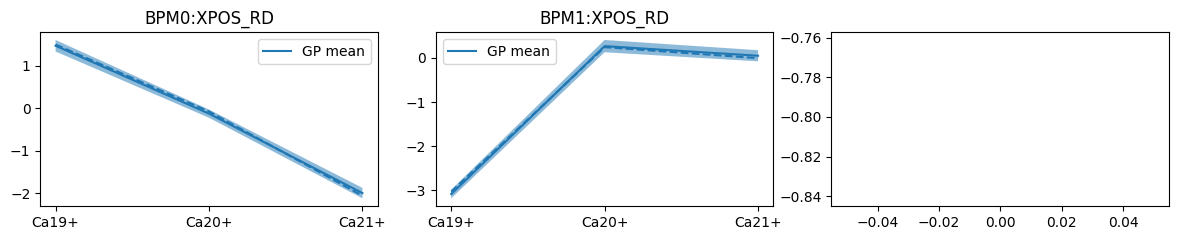

In [12]:
fig,ax = plot_msGP_over_states(
    msbo.msGP,
    control_values=control_values,
    control_data_labels = ["init"],
    state_names = state_names,
    objective_PVs = objective_PVs,
    multi_state_objective_fn = multi_state_objective_fn,
    CL = 3,
)

l_ytrue = np.zeros((len(control_values),n_state,n_obj))
l_obj = np.zeros(len(control_values))

for i,x in enumerate(control_values):
    for istate in range(n_state):
        future = msbo.evaluator.submit(x,istate=istate)
        df, df_ramp  = msbo.evaluator.get_result(future)
        y = df[objective_PVs].mean().values
        l_ytrue[i,istate,:] = y
    l_obj[i] = multi_state_objective_fn(torch.tensor(l_ytrue[i,:,:])).item()

for i_obj in range(n_obj):
    for i_c in range(len(control_values)):
        ax[i_obj].plot(np.arange(n_state),l_ytrue[i_c,:,i_obj],'--C'+str(i_c))
ax[i_obj+1].plot(np.arange(len(control_values)),l_obj,'--k')

# 1st globalBO

In [13]:
msbo.optimize_global(neval=n_eval, beta=beta)
candidate = msbo.query_candidate(msbo.control_bounds_botorch, beta=0.0)
control_values = np.vstack((control_values,candidate))

In [14]:
# projection_plot(msbo,candidate)

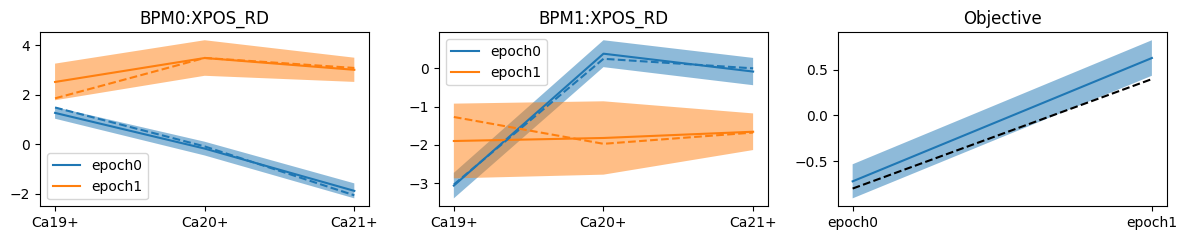

In [15]:
fig,ax = plot_msGP_over_states(
    msbo.msGP,
    control_values=control_values,
    control_data_labels = ["epoch0","epoch1"],
    state_names = state_names,
    objective_PVs = objective_PVs,
    multi_state_objective_fn = multi_state_objective_fn,
    CL = 3,
)

l_ytrue = np.zeros((len(control_values),n_state,n_obj))
l_obj = np.zeros(len(control_values))

for i,x in enumerate(control_values):
    for istate in range(n_state):
        future = msbo.evaluator.submit(x,istate=istate)
        df, df_ramp  = msbo.evaluator.get_result(future)
        y = df[objective_PVs].mean().values
        l_ytrue[i,istate,:] = y
    l_obj[i] = multi_state_objective_fn(torch.tensor(l_ytrue[i,:,:])).item()

for i_obj in range(n_obj):
    for i_c in range(len(control_values)):
        ax[i_obj].plot(np.arange(n_state),l_ytrue[i_c,:,i_obj],'--C'+str(i_c))
ax[i_obj+1].plot(np.arange(len(control_values)),l_obj,'--k')

# 2nd globalBO

In [16]:
msbo.optimize_global(neval=n_eval, beta=beta)
candidate = msbo.query_candidate(msbo.control_bounds_botorch, beta=0.0)
control_values = np.vstack((control_values,candidate))

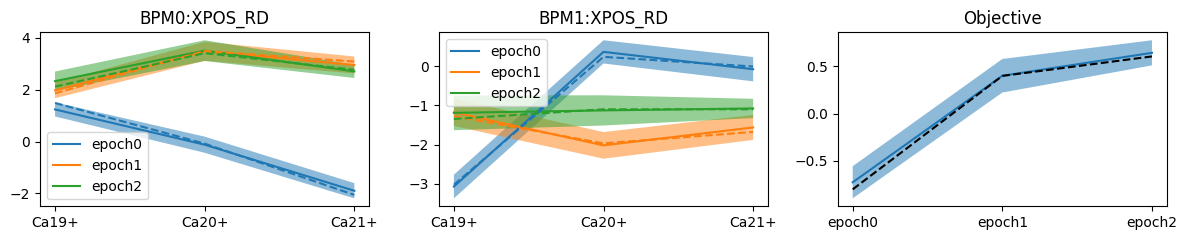

In [17]:
fig,ax = plot_msGP_over_states(
    msbo.msGP,
    control_values=control_values,
    control_data_labels = ["epoch0","epoch1","epoch2"],
    state_names = state_names,
    objective_PVs = objective_PVs,
    multi_state_objective_fn = multi_state_objective_fn,
    CL = 3,
)

l_ytrue = np.zeros((len(control_values),n_state,n_obj))
l_obj = np.zeros(len(control_values))

for i,x in enumerate(control_values):
    for istate in range(n_state):
        future = msbo.evaluator.submit(x,istate=istate)
        df, df_ramp  = msbo.evaluator.get_result(future)
        y = df[objective_PVs].mean().values
        l_ytrue[i,istate,:] = y
    l_obj[i] = multi_state_objective_fn(torch.tensor(l_ytrue[i,:,:])).item()

for i_obj in range(n_obj):
    for i_c in range(len(control_values)):
        ax[i_obj].plot(np.arange(n_state),l_ytrue[i_c,:,i_obj],'--C'+str(i_c))
ax[i_obj+1].plot(np.arange(len(control_values)),l_obj,'--k')

In [18]:
msbo.msGP.l_train_X[0][:n_init]

tensor([[0.6564, 0.8931],
        [0.7118, 0.8683],
        [0.3043, 0.6563],
        [0.0194, 0.4636],
        [0.9967, 0.0601]], dtype=torch.float64)

In [19]:
msbo.msGP.l_train_X[0][n_init:n_init+n_eval]

tensor([[7.2721e-01, 4.2429e-01],
        [4.0208e-04, 3.0676e-04],
        [3.5251e-01, 4.3979e-04],
        [1.0006e+00, 5.9352e-01],
        [6.1989e-04, 1.0005e+00]], dtype=torch.float64)

In [20]:
msbo.msGP.l_train_X[0][n_init+n_eval:]

tensor([[3.1330e-01, 1.0006e+00],
        [7.2570e-01, 3.0473e-04],
        [3.9005e-01, 1.0004e+00],
        [1.6106e-01, 7.9923e-01],
        [1.0006e+00, 3.5871e-01]], dtype=torch.float64)

[████████████████████████████████████████] 100%/100%



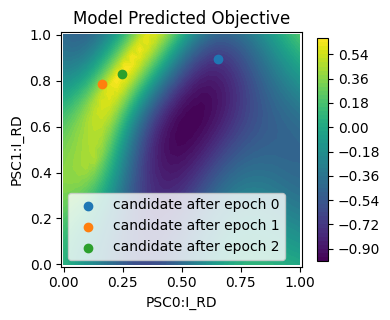

In [21]:
projection_plot_model(msbo,control_values,data_only=False)

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%



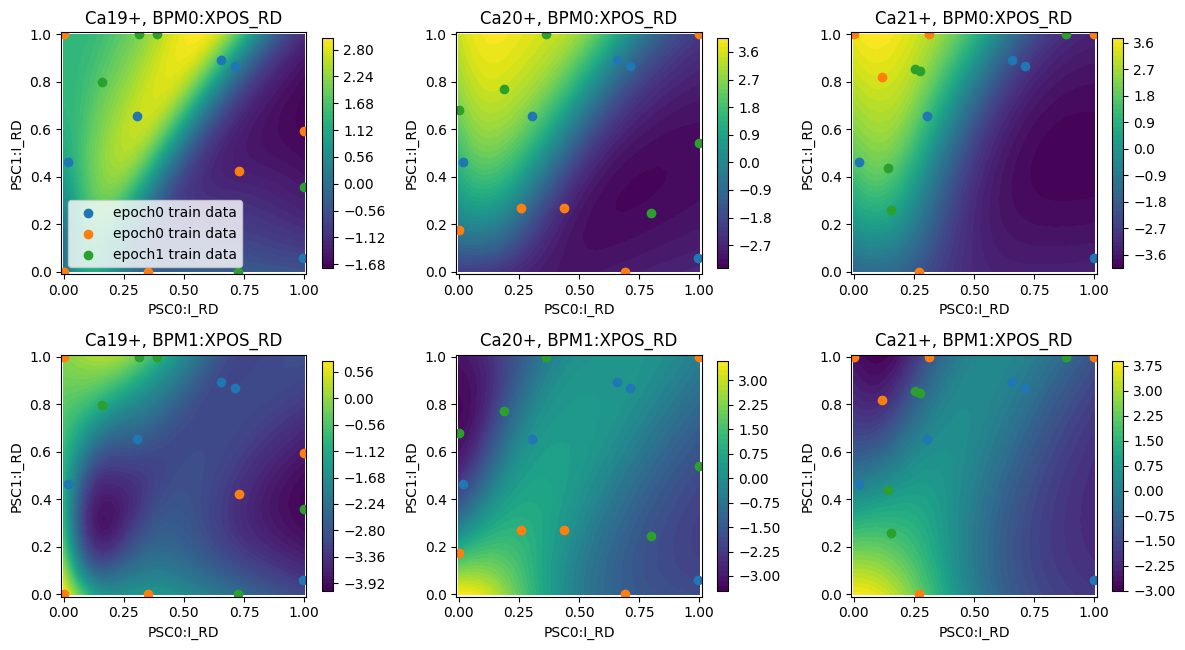

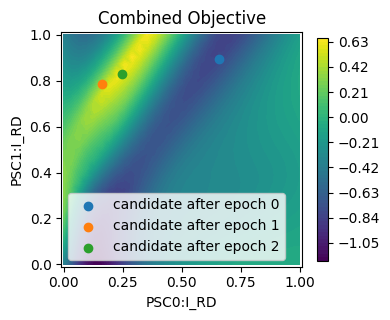

In [22]:
projection_plot(msbo,control_values,data_only=False)